In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/Data Glacier Internship/Week 7')

Mounted at /content/drive


**Problem Statement:**

   The term hate speech is understood as any type of verbal, written or behavioural communication that attacks or uses derogatory or discriminatory language against a person or group based on what they are, in other words, based on their religion, ethnicity, nationality, race, colour, ancestry, sex or another identity factor. In this problem, we will take you through a hate speech detection model with Machine Learning and Python.
   
   Hate Speech Detection is generally a task of sentiment classification. So, for training, a model that can classify hate speech from a certain piece of text can be achieved by training it on a data that is generally used to classify sentiments. So, for the task of hate speech detection model, we will use the Twitter tweets to identify tweets containing Hate speech.


**Business Understanding:**

Detection of hate speech in tweets is an important issue for businesses to 
consider for several reasons.

First, hate speech can be harmful and offensive to individuals and groups, and 
businesses have a social responsibility to address it. In addition, businesses 
may face legal and reputational risks if they fail to address hate speech on their platforms.

Second, businesses that operate social media platforms or engage in social 
media marketing may need to monitor and address hate speech to maintain 
the trust and loyalty of their users and customers. If a business is perceived as tolerating hate speech, it may face backlash from users and negative media 
attention.

Finally, businesses may also have a financial incentive to address hate speech, 
as it can negatively impact the user experience and drive users away from the 
platform.

To detect hate speech in tweets, businesses may use a combination of 
automated tools and human moderation. Automated tools may include 
machine learning algorithms that are trained to identify hate speech based on 
certain characteristics, such as the use of certain words or phrases. Human 
moderation may involve a team of moderators who review tweets and take 
appropriate action, such as deleting the tweet or banning the user.

It's important to note that detecting hate speech can be challenging, as it may 
involve complex issues of context and intent. It is also important for businesses 
to consider the potential for false positives and ensure that their approaches 
to detecting and addressing hate speech are fair and transparent.

Import the necessary libraries.

In [2]:
import numpy as np
import pandas as pd

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt


## ignore warnings
import warnings
warnings.filterwarnings("ignore",module = "matplotlib\..*")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Load the data.

In [3]:
train_data = pd.read_csv('train_E6oV3lV.csv')
test_data = pd.read_csv('test_tweets_anuFYb8.csv')

Let's print the first few rows to get an idea of our data.

In [4]:
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Feature description:
  - 'id' : primary key of our dataset, but we will not need it.
  - 'label' : 0 for free speech and 1 for hate speech
  - 'tweet' : contains the tweets we want to classify as free speech or hate speech

In [5]:
## drop the id column
train_data.drop('id', axis=1, inplace=True)

Shape of the datasets.

In [6]:
print(f'Shape of training data: {train_data.shape}')
print(f'Shape of test data: {test_data.shape}')

Shape of training data: (31962, 2)
Shape of test data: (17197, 2)


Let's check the type of each feature, and if there are any null values or duplicated rows.

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [8]:
## check for duplicates
print(f'There are {train_data.duplicated().sum()} duplicated rows.')

There are 2432 duplicated rows.


The type of the features is correct and there aren't any null values. However, there are $2432$ duplicated rows. Let's remove them.

In [9]:
train_data.drop_duplicates(inplace=True)

Let's check for imbalanced data.

In [10]:
## check for imbalanced data
train_data['label'].value_counts()

0    27517
1     2013
Name: label, dtype: int64

The data are highly imbalanced. Let's try a downsampling and an oversampling technique to address this issue. We will later choose which is more suitable.

In [11]:
# Import the RandomUnderSampler/RandomOverSampler class
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
# Split the data into features and labels
X = train_data[['tweet']]
y = train_data['label']

# Create a RandomUnderSampler/RandomOverSampler object
undersampler = RandomUnderSampler()
#oversampler = RandomOverSampler()

# transform the data
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)
#X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

# Create a downsampled/upsampled dataframe
data_downsampled = pd.DataFrame({'tweet': X_undersampled['tweet'], 'label': y_undersampled})
#data_upsampled = pd.DataFrame({'tweet': X_oversampled['tweet'], 'label': y_oversampled})

In [12]:
data_downsampled.shape

(4026, 2)

In [13]:
data_downsampled['label'].value_counts()

0    2013
1    2013
Name: label, dtype: int64

**Data Cleaning**

The 'tweet' column contains text data that we need to clean. Namely, we will take the following steps to clean our data:
- lowercase the text
- apply tokenization and lemmatization
- remove stop-words
- remove one-letter words
- remove tags and other special characters
- remove non-ASCII characters

In [14]:
def clean_text(text):
    
    # tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    

    ## lemmatize + lowercase
    lemmatizer = WordNetLemmatizer()
    for word in text.split():
          token = lemmatizer.lemmatize(word.lower(), pos='v')
             
    
    ## remove stopwords
    keep_words = [token for token in tokens if token not in stopwords.words('english')]
    row_text = ' '.join(keep_words)
    row_text = ' '.join([word for word in row_text.split() if len(word)>1])  ## remove one letter words
    row_text = re.sub(r'\w*\d\w*', '', row_text).strip()


    return row_text

In [15]:
train2 = data_downsampled.copy()
train2.head()

,tweet,label
0,âthe truth is rarely pure and never simple.â...,0
1,why are you so close?? #voiceover #cat #monke...,0
2,be ... have #success... in that order!,0
3,aladdin on the tv today on my bihday then alad...,0
4,stop tweeting. you're a narcissistic piece of ...,0


In [16]:
## apply the clean_text function to the 'tweet' column
train2['tweet'] = train2['tweet'].apply(clean_text)

In [17]:
## remove non-ASCII characters
train2.replace(regex=True, to_replace =['¢','€','£', 'Ã', '¬', 'Ð', '±','½','©','•',
                                    '¾', '§', '¥', '«', '¤', '–', 'œ', '¡', '”', 
                                    '|', 'â', '™', 'Â', 'Î', '¿', 'µ', '´', '‡',
                                    '»', 'Ž', '®', 'º', 'Ï', 'ƒ', '¶', '¹', '┬',
                                    'á', 'Γ', 'Ç', 'Ö', 'ð'], value='', inplace=True)

In [18]:
train2.head(n=10)

,tweet,label
0,truth rarely pure never simple friend friends ...,0
1,close voiceover cat monkey hoodcomedy bestvine...,0
2,success order,0
3,aladdin tv today bihday aladdin theatre thursd...,0
4,stop tweeting narcissistic piece trash amp try...,0
5,believe rock role dongiovanni user,0
6,bitches hate dislike stalk dont even know even...,0
7,user tragic america continues okay seeing inno...,0
8,user im half boy half man im dumb,0
9,juan happy love story house blessing video jua...,0


In [19]:
# WordCloud of Hate/Free speech
hate_speech = train2[train2['label'] == 1]['tweet']
free_speech = train2[train2['label'] == 0]['tweet']
hate_words = ''
free_words = ''

stop_words = set(STOPWORDS)
for text in hate_speech:    
   
    #split the text
    hate_tokens = text.split()   
    hate_words += ' '.join(hate_tokens) + ' '

for text in free_speech:

    free_tokens = text.split()
    free_words += ' '.join(free_tokens) + ' '
 
hate_word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(hate_words)

free_word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(free_words)


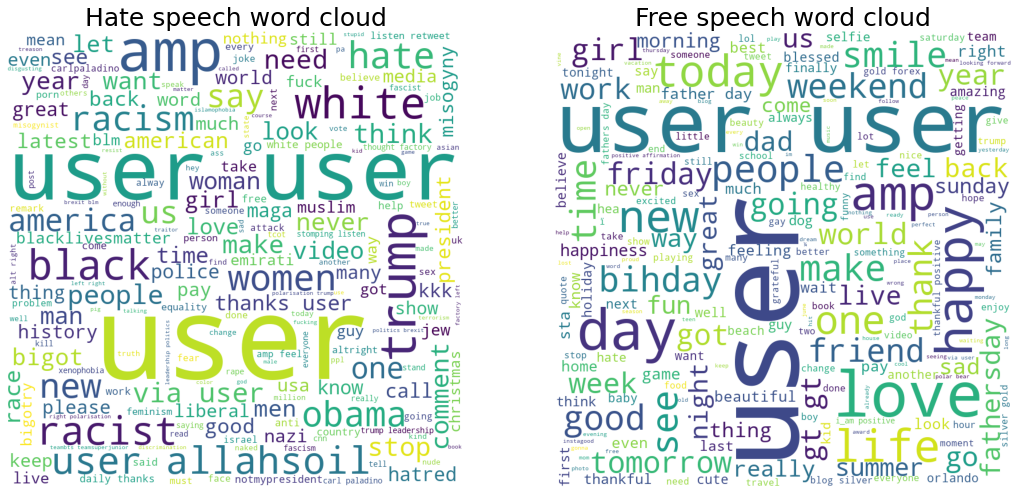

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,12))

ax1.set_title('Hate speech word cloud', fontsize = 25)
im1 = ax1.imshow(hate_word_cloud)
ax1.axis("off")

ax2.set_title('Free speech word cloud',fontsize = 25)
im2 = ax2.imshow(free_word_cloud)
ax2.axis("off")

plt.show()

Now that our data is cleaned and balanced, we will split them into training and testing data.

In [21]:
## training-testing data
X_train, X_test, y_train, y_test = train_test_split(train2['tweet'], train2['label'], test_size=0.2)

In [22]:
## convert to pandas dataframes
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

**Feature Extraction using TF-IDF, short for term frequency–inverse document frequency. TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.**

In [23]:
# Vectorize the training data using the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features= 2000)
X_train2 = vectorizer.fit_transform(X_train['tweet']).toarray()
X_test2 = vectorizer.fit_transform(X_test['tweet']).toarray()

In [24]:
# Convert the dense arrays to a tensors
train_input_tensor = torch.tensor(X_train2)
test_input_tensor = torch.tensor(X_test2)